Magnitude min: 0.0 Magnitude max: 15.81


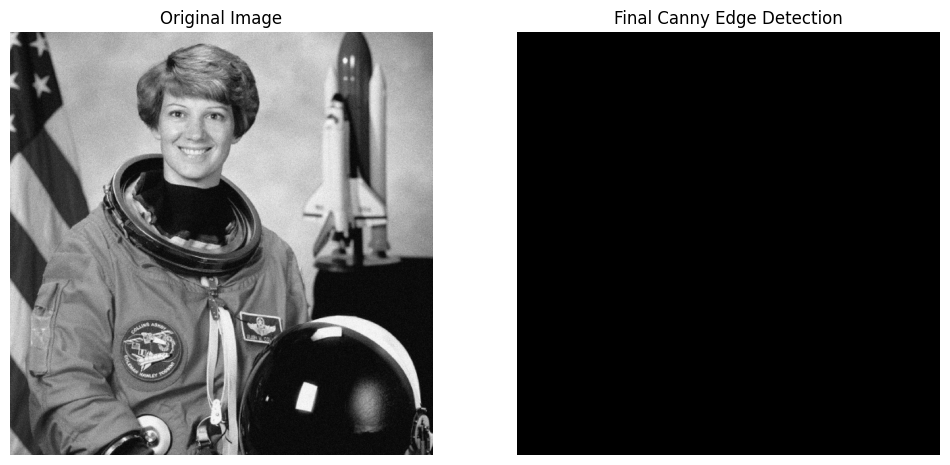

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. 가우시안 커널 정의
def gaussian_kernel(size: int, sigma: float):
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma ** 2)) * np.exp(- ((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma ** 2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

# 2. 가우시안 블러링 적용
def gaussian_blur(image, kernel_size=5, sigma=1.4):
    kernel = gaussian_kernel(kernel_size, sigma)
    return cv2.filter2D(image, -1, kernel)

# 3. Sobel 필터로 기울기 계산
def sobel_edges(image):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    gradient_x = cv2.filter2D(image, -1, sobel_x)
    gradient_y = cv2.filter2D(image, -1, sobel_y)

    # 기울기의 크기와 방향 계산
    magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    direction = np.arctan2(gradient_y, gradient_x) * 180 / np.pi
    direction = np.mod(direction + 180, 180)  # 방향을 [0, 180] 범위로 조정

    # 기울기 크기와 방향 확인
    print("Magnitude min:", np.min(magnitude), "Magnitude max:", np.max(magnitude))

    return magnitude, direction

# 4. 비최대 억제 (Non-Maximum Suppression)
def non_maximum_suppression(magnitude, direction):
    rows, cols = magnitude.shape
    result = np.zeros((rows, cols), dtype=np.float32)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            angle = direction[i, j]

            # Edge 방향을 기준으로 이웃 픽셀 선택
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                neighbors = [magnitude[i, j - 1], magnitude[i, j + 1]]
            elif 22.5 <= angle < 67.5:
                neighbors = [magnitude[i - 1, j + 1], magnitude[i + 1, j - 1]]
            elif 67.5 <= angle < 112.5:
                neighbors = [magnitude[i - 1, j], magnitude[i + 1, j]]
            elif 112.5 <= angle < 157.5:
                neighbors = [magnitude[i - 1, j - 1], magnitude[i + 1, j + 1]]

            # 최대값만 유지
            if magnitude[i, j] >= max(neighbors):
                result[i, j] = magnitude[i, j]

    return result

# 5. 히스테리시스 임계값 처리 (Hysteresis Thresholding)
def hysteresis_thresholding(image, low_threshold, high_threshold):
    strong = 255
    weak = 50
    result = np.zeros_like(image, dtype=np.uint8)

    strong_edges = (image >= high_threshold)
    weak_edges = (image >= low_threshold) & ~strong_edges

    result[strong_edges] = strong
    result[weak_edges] = weak

    # 연결된 weak edge를 strong으로 변경
    rows, cols = image.shape
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if result[i, j] == weak:
                if np.any(result[i - 1:i + 2, j - 1:j + 2] == strong):
                    result[i, j] = strong
                else:
                    result[i, j] = 0
    return result

# 이미지 읽기
image = cv2.imread('example.jpg', cv2.IMREAD_GRAYSCALE)

# 이미지가 제대로 로드되었는지 확인
if image is None:
    raise ValueError("이미지를 로드할 수 없습니다. 경로를 확인하세요.")

# 1. 가우시안 블러링 적용
blurred_image = gaussian_blur(image)

# 2. Sobel 필터로 기울기 계산
magnitude, direction = sobel_edges(blurred_image)

# 3. 비최대 억제 적용
suppressed_image = non_maximum_suppression(magnitude, direction)

# 4. 히스테리시스 임계값 처리 적용
final_edges = hysteresis_thresholding(suppressed_image, 50, 150)

# 결과 출력
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Final Canny Edge Detection")
plt.imshow(final_edges, cmap='gray')
plt.axis('off')

plt.show()
